# **ConvNet 2 - Data Augmentation, Dropout**
## **Part 1 Data Augmentation**
Data augmentation takes the approach of generating more training data from existing training samples, by “augmenting” the samples via a number of random transformations that yield believable-looking images. The common-sense approach would be the manual creation of more images and applying small changes. However, it can be done easier and more efficiently in Keras, using ImageDataGenerator.

The goal is that at training time, our model would never see the exact same picture twice. It will change each image at the loading stage. This helps the model get exposed to more aspects of the data and generalize better. Below you can see an example. Where before we use only the rescale parameter, there are now several other random transformations:

In [1]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

2023-11-09 21:58:43.237289: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 21:58:43.237404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 21:58:43.237539: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 21:58:44.782887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 21:58:48.927545: W tensorflow/compiler/

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:
- `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
- `width_shift` and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally – relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [2]:
from keras import layers
from keras import models

#Create data augmentation as a separate model
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.1),
    ]
)

# Nest data augmentation model as a layer
model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(scale=1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [3]:
import keras
learning_rate = 1e-4
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [4]:
model.build(input_shape=(None, 150, 150, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                 

Let's take a look at our augmented images:

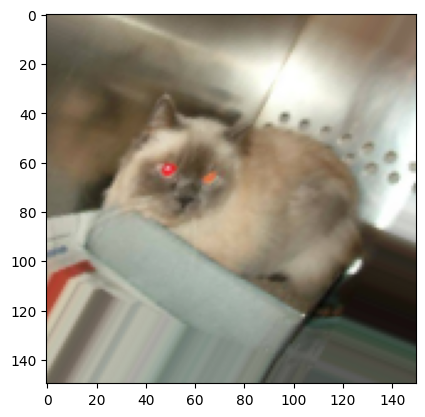

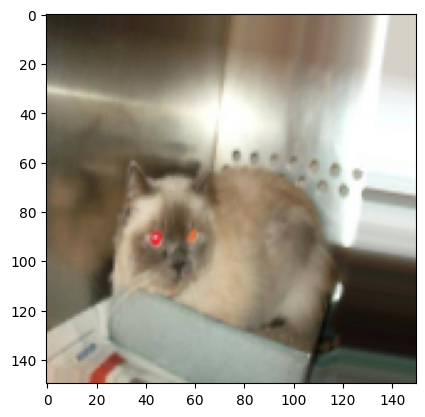

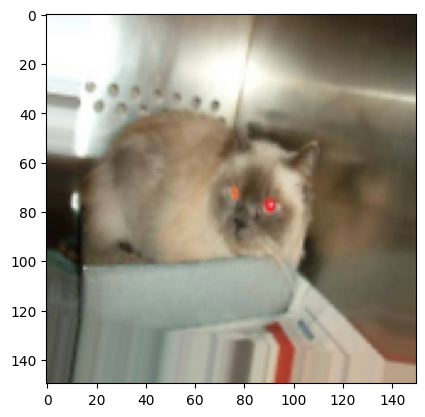

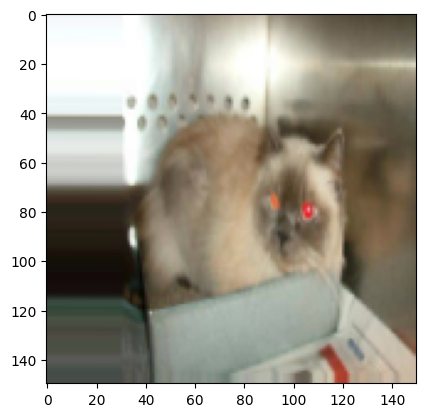

In [5]:
# This is module with image preprocessing utilities
from keras.preprocessing import image
from matplotlib import pyplot as plt
import os

train_cats_dir = './dogs-vs-cats/train/'
 
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]
 
# We pick one image to "augment"
img_path = fnames[3]
 
# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))
 
# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)
 
# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)
 
# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
 
plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images, so the results won't be that much better.

Train the network using data augmentation:

In [6]:
from tensorflow.keras.preprocessing import  image_dataset_from_directory

train_dir = 'cats_and_dogs_small/train'
train_dataset = image_dataset_from_directory(
    train_dir,  # This is the target directory
    labels="inferred", 
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(150,150), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

validation_dir = 'cats_and_dogs_small/validation'
validation_dataset = image_dataset_from_directory(
    validation_dir,  # This is the target directory
    labels="inferred", 
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(150,150), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

test_dir = 'cats_and_dogs_small/test'
test_dataset = image_dataset_from_directory(
    test_dir,  # This is the target directory
    labels="inferred", 
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(150,150), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [8]:
model_fit = model.fit(train_dataset, epochs=100, validation_data=validation_dataset)

Epoch 1/100
100/100 [==============================] - 36s 356ms/step - loss: 0.6873 - accuracy: 0.5445 - val_loss: 0.6773 - val_accuracy: 0.5950
Epoch 2/100
100/100 [==============================] - 49s 487ms/step - loss: 0.6734 - accuracy: 0.5905 - val_loss: 0.6754 - val_accuracy: 0.5510
Epoch 3/100
100/100 [==============================] - 55s 553ms/step - loss: 0.6592 - accuracy: 0.6025 - val_loss: 0.6348 - val_accuracy: 0.6670
Epoch 4/100
100/100 [==============================] - 56s 558ms/step - loss: 0.6428 - accuracy: 0.6230 - val_loss: 0.6170 - val_accuracy: 0.6830
Epoch 5/100
100/100 [==============================] - 56s 562ms/step - loss: 0.6204 - accuracy: 0.6745 - val_loss: 0.6687 - val_accuracy: 0.5760
Epoch 6/100
100/100 [==============================] - 56s 556ms/step - loss: 0.6068 - accuracy: 0.6740 - val_loss: 0.5977 - val_accuracy: 0.6840
Epoch 7/100
100/100 [==============================] - 55s 554ms/step - loss: 0.5920 - accuracy: 0.6860 - val_loss: 0.5897 -

Note, that this time we train the network longer (for about 100 epochs) and it still increases. If training takes too much time on your machine, you can try lower numbers. After 100 epochs you can expect validation accuracy of about 80-82%, after 30 epochs about 77%. Plot the results of 30 epochs and compare them with those without augmentation.

In [13]:
dict = model_fit.history
dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [19]:
import matplotlib.pyplot as plt

def plot_metric(dict, metric, epochs_num = len(dict['loss'])):
    plt.clf()  # clear figure
    loss_values = dict[metric][0:epochs_num]
    val_loss_values = dict[f'val_{metric}'][0:epochs_num]
    epochs = range(1, epochs_num + 1)
    plt.plot(epochs, loss_values, 'go', label=f'Training {metric}')
    plt.plot(epochs, val_loss_values, 'bo', label=f'Validation {metric}')
    plt.title(f'Training and validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

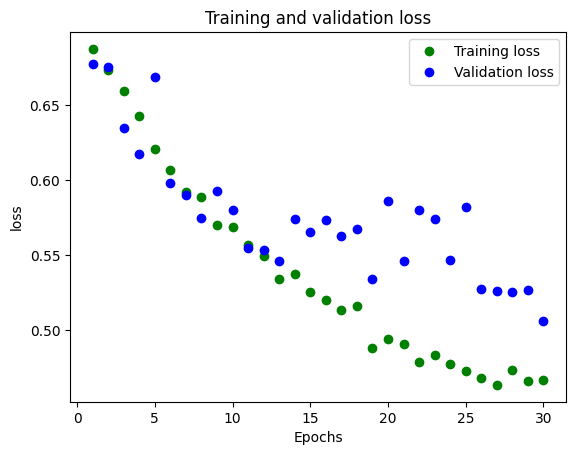

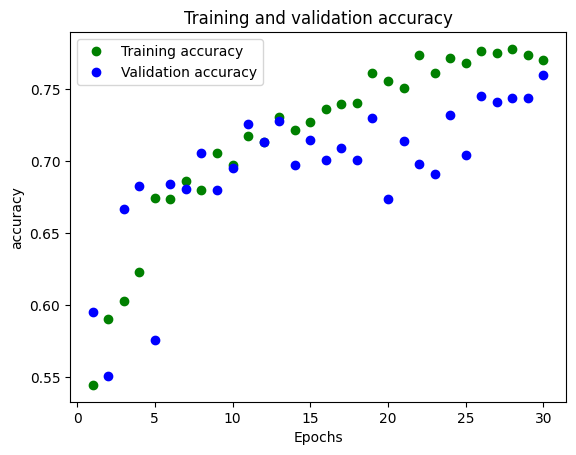

In [18]:
# Plot the results for 30 epochs
plot_metric(dict, 'loss', 30)
plot_metric(dict, 'accuracy', 30)

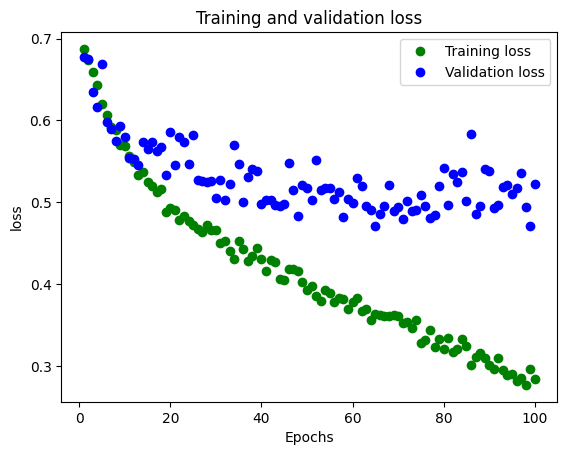

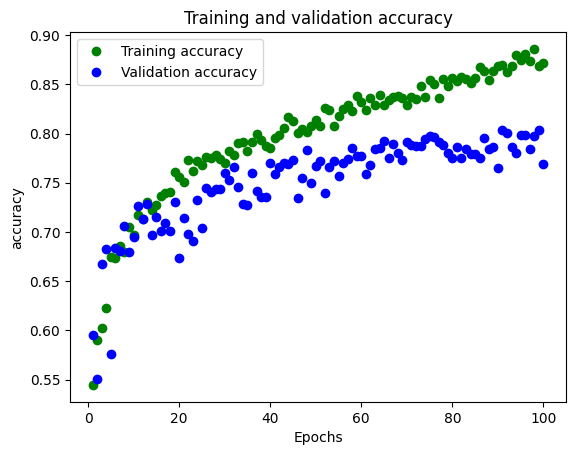

In [20]:
# Plot the results for all epochs
plot_metric(dict, 'loss')
plot_metric(dict, 'accuracy')

## **Part 2 Adding Dropout Layer**
A dropout layer is a very simple, yet quite counter-intuitive method. What it does is basically cutting off half of the connection between the layers. You may ask yourself a question - Why do I train the network so hard, only to randomly throw half of the information away? Surprisingly, this works. In many situations network is overfitting to the data so much, that randomly cutting 20%, 30%, or even 50% of connection during training phase will be beneficial.

Therefore, to further combat overfitting, we will also add a Dropout layer to our Dogs and Cats example. Please configure the model with the same four convolutional layers and four max-pooling layers like last week, but this time add the Dropout layer right before the densely-connected classifier (with parameter 0.5).

In [16]:
#TODO: Implement the model
dropout_model = models.Sequential()
dropout_model.add(layers.Dropout(0.5))
dropout_model.add(data_augmentation)
dropout_model.add(layers.Rescaling(scale=1./255))
dropout_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Flatten())
dropout_model.add(layers.Dense(512, activation='relu'))
dropout_model.add(layers.Dense(1, activation='sigmoid'))

#TODO: Compile the model
dropout_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

dropout_model.build(input_shape=(None, 150, 150, 3))
dropout_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 150, 150, 3)       0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                      

In [22]:
dropout_model_fit = dropout_model.fit(train_dataset, epochs=100, validation_data=validation_dataset)

Epoch 1/100
100/100 [==============================] - 65s 648ms/step - loss: 0.6603 - accuracy: 0.5930 - val_loss: 0.6483 - val_accuracy: 0.6570
Epoch 2/100
100/100 [==============================] - 68s 675ms/step - loss: 0.6461 - accuracy: 0.6175 - val_loss: 0.6381 - val_accuracy: 0.6630
Epoch 3/100
100/100 [==============================] - 55s 550ms/step - loss: 0.6396 - accuracy: 0.6395 - val_loss: 0.6365 - val_accuracy: 0.6770
Epoch 4/100
100/100 [==============================] - 54s 538ms/step - loss: 0.6252 - accuracy: 0.6485 - val_loss: 0.6503 - val_accuracy: 0.6100
Epoch 5/100
100/100 [==============================] - 54s 543ms/step - loss: 0.6279 - accuracy: 0.6415 - val_loss: 0.6177 - val_accuracy: 0.6690
Epoch 6/100
100/100 [==============================] - 54s 541ms/step - loss: 0.6172 - accuracy: 0.6570 - val_loss: 0.6048 - val_accuracy: 0.6960
Epoch 7/100
100/100 [==============================] - 54s 540ms/step - loss: 0.6020 - accuracy: 0.6690 - val_loss: 0.6005 -

Wy should expect higher accuracy, about 80-82% compared to 77-80% in the previous lab. Plot the results and compare them.

In [24]:
dropout_dict = model_fit.history
dropout_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

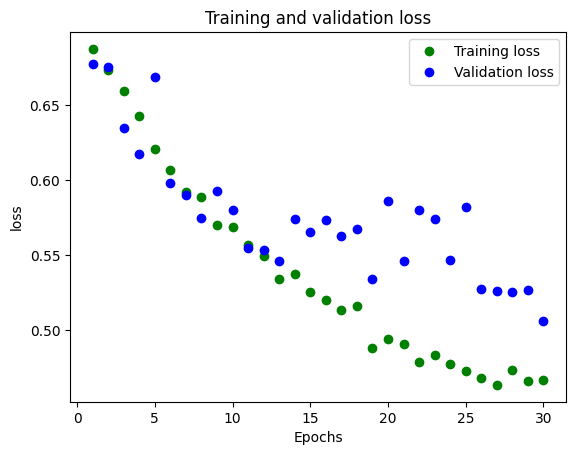

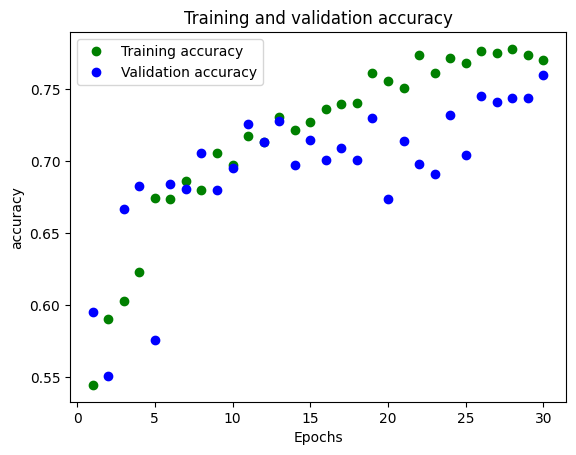

In [25]:
# Plot the results for 30 epochs
plot_metric(dropout_dict, 'loss', 30)
plot_metric(dropout_dict, 'accuracy', 30)

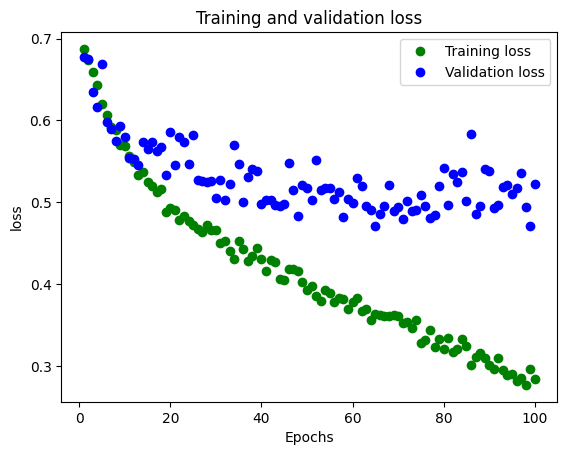

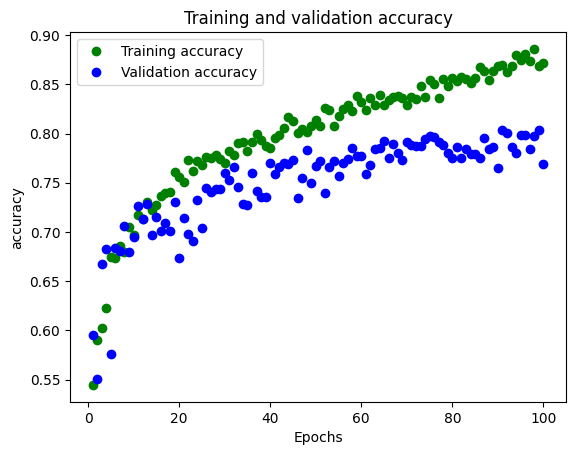

In [26]:
# Plot the results for all epochs
plot_metric(dropout_dict, 'loss')
plot_metric(dropout_dict, 'accuracy')

If you want, you can also try training the model with a dropout layer, but without image augmentation, to see which one is better. Both methods should give better results than training without any of them, but worse than having them combined. You may, however, notice, that dropout is faster.

If you want, you can change the dropout parameter. Maybe we cut off too much? You can also try to experiment with putting the dropout layer in different places (maybe between convolutions), or even adding more dropout layers. There is hardly ever one universal way to implement a model. Make some modifications and comment on the results.